In [1]:
url = 'http://opendap.deltares.nl/thredds/dodsC/opendap/rijkswaterstaat/waterbase/27_Waterhoogte_in_cm_t.o.v._normaal_amsterdams_peil_in_oppervlaktewater/nc/id1-BROUWHVSGT08.nc'

In [2]:
import datetime

import pandas as pd
import xarray
import matplotlib.pyplot as plt

In [3]:
# open dataset
ds = xarray.open_dataset(url)

In [4]:
# get first location (only 1 location in file)
ssh = ds.sea_surface_height[0]

In [5]:
# convert to dataframe
df = pd.DataFrame(ssh.to_pandas(), columns=['ssh'])

In [6]:
# check number of measurements per year
# this data is up to date until 2018-09
# after that waterbase was is no longer available.
# the updates based on DDL are not yet available
counts = df.resample('A', label='left').count()
print(counts.head(n=3))
print(counts.tail(n=3))

             ssh
time            
1978-12-31     2
1979-12-31  8784
1980-12-31  8760
              ssh
time             
2015-12-31  52704
2016-12-31  52560
2017-12-31  35943


In [7]:
# drop incomplete years
df = df[df.index > datetime.datetime(1980, 1, 1)]
df = df[df.index < datetime.datetime(2018, 1, 1)]


Text(0.5, 1.0, 'Annual mean')

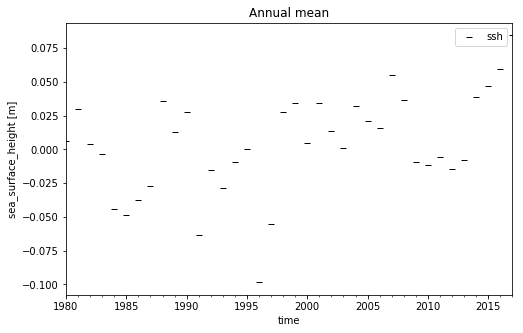

In [8]:
# plot measured data (labels are a bit off)
fig, ax = plt.subplots(figsize=(8, 5))
annual_mean_df = df.resample('A', label='right').mean()
annual_mean_df.plot(style='k_', ax=ax)
ax.set_ylabel("{} [{}]".format(ssh.standard_name, ssh.units))
ax.set_title('Annual mean')

Text(0.5, 1.0, 'Annual max (values at end of period)')

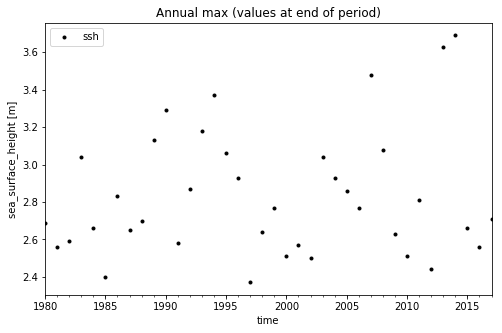

In [9]:
# plot annual maxima
fig, ax = plt.subplots(figsize=(8, 5))
df.resample('A', label='right').max().plot(style='k.', ax=ax)
ax.set_ylabel("{} [{}]".format(ssh.standard_name, ssh.units))
ax.set_title('Annual max (values at end of period)')

In [10]:
import statsmodels.regression.linear_model 
import statsmodels.api as sm
import numpy as np


In [11]:
# define the statistical model
def linear_model(df, with_ar=True):
    y = df['height']
    X = np.c_[
        df['year']-1970, 
        np.cos(2*np.pi*(df['year']-1970)/18.613),
        np.sin(2*np.pi*(df['year']-1970)/18.613)
    ]
    month = np.mod(df['year'], 1) * 12.0
    names = ['Constant', 'Trend', 'Nodal U', 'Nodal V']
    X = sm.add_constant(X)
    if with_ar:
        model = sm.GLSAR(y, X, missing='drop', rho=1)
    else:
        model = sm.OLS(y, X, missing='drop')
    fit = model.fit(cov_type='HC0')
    return fit, names

In [12]:
year = [x.year for x in annual_mean_df.index]
annual_mean_df['year'] = year
# m to mm
annual_mean_df['height'] = annual_mean_df['ssh'] * 1000


In [13]:
fit, names = linear_model(annual_mean_df)
prediction = fit.get_prediction()
fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                           GLSAR Regression Results                           
==============================================================================
Dep. Variable:                 height   R-squared:                       0.317
Model:                          GLSAR   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     5.949
Date:                Thu, 25 Apr 2019   Prob (F-statistic):            0.00233
Time:                        23:43:16   Log-Likelihood:                -179.32
No. Observations:                  37   AIC:                             366.6
Df Residuals:                      33   BIC:                             373.1
Df Model:                           3                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -54.8593     17.873     -3.069      0.002     -89.889     -19.829
x1             2.0208      0.522      3.874      0.000       0.998       3.043
x2            -1.5794      8.248     -0.191      0.848     -17.745      14.586
x3           -19.1110      6.761     -2.827      0.005     -32.361      -5.861
==============================================================================
Omnibus:                        1.283   Durbin-Watson:                   1.341
Prob(Omnibus):                  0.526   Jarque-Bera (JB):                0.876
Skew:                          -0.377   Prob(JB):                        0.645
Kurtosis:                       2.967   Cond. No.                         98.6
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

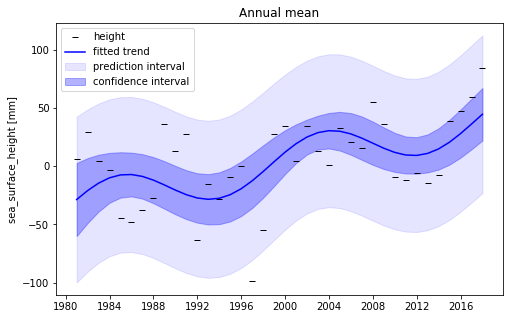

In [14]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(annual_mean_df.index, annual_mean_df.height, 'k_')
ax.set_ylabel("{} [{}]".format(ssh.standard_name, 'mm'))
ax.set_title('Annual mean')
conf_int = prediction.conf_int()
pred_int = prediction.conf_int(obs=True)
ax.fill_between(annual_mean_df.index, pred_int[:, 0], pred_int[:, 1], alpha=0.1, color='blue', label='prediction interval')
ax.fill_between(annual_mean_df.index, conf_int[:, 0], conf_int[:, 1], alpha=0.3, color='blue', label='confidence interval')
ax.plot(annual_mean_df.index, fit.predict(), color='blue', label='fitted trend')
ax.legend()
